RLudwig: This notebook contains a credit card portfolio of past due accounts for a probability of payment prediction model that was obtained by using Amazon Sagemaker. First I performed a Principal Component Analysis(PCA) reduction followed by utilizing the XGboost algorithm with a binary logistic objective and Area under the Curve (AUC) key metric. Hyperparameter tuning was performed using random search. Predictions were made on the best performing model utilizing AWS Batch Transform. A secondary score called Benefit Score was created by squaring the optimal XGboost score and multiplying it by the outstanding balance. The Benefit Score is a useful way to offset the fact that balance and collectibility are usually negatively correlated in a linear fashion. It is especially useful for companies that work past due accounts on a contingency basis receiving revenue as a percent of what they collect.  

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sagemaker
import boto3
import io  
import sagemaker.amazon.common as smac # sagemaker common libary
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle


In [433]:
df = pd.read_stata("cc_oa_carga_historica_pythn_prjct.dta")

## Part 1. Data Cleaning and Analysis

clean up pago_general column to get 0 for no payment and 1 for payment

In [434]:
df['pago_general'] = df['pago_general'].replace(['master only (1)'],'1')

In [435]:
df['pago_general'] = pd.to_numeric(df['pago_general'], errors='coerce')

In [436]:
df.head()

,location,banco,agencia,dir_reg,dt_nasc,uf,iden_tel1,ddd_tel1,iden_tel2,ddd_tel2,...,saldo_ccmrcl6,mesasig,dataasig,pj,cnpj15,cpf11,cpfcnpj15,valorpagamento,datapagamento,pago_general
0,010102,237,0313,4354,20/01/1994,SP,X,00,V,11,...,741.700012,201902,2019-02-27,1.0,000001813000104,00000181304,000001813000104,2369.94,22/01/2019,1
1,101010,,00309,,19/02/1963,RJ,V,21,X,00,...,0.000000,201901,2019-01-31,0.0,000002457000004,00000245704,00000000245704,NaN,,0
2,101010,,00685,,23/12/1982,CE,X,00,X,00,...,0.000000,201812,2018-12-11,0.0,000002683000021,00000268321,00000000268321,NaN,,0
3,101010,,00679,,15/02/1986,PA,X,00,X,00,...,0.000000,201901,2019-01-28,0.0,000003672000022,00000367222,00000000367222,368.74,01/02/2019,1
4,101010,,04025,,17/06/1963,RJ,X,00,X,00,...,0.000000,201901,2019-01-04,0.0,000004527000069,00000452769,00000000452769,NaN,,0


In [437]:
df.describe()

,vl_vcto_cor,resp_contr,resp_cliente,dias_atraso,saldo_totcli6,saldo_cart6,saldo_ccmrcl6,pj,valorpagamento,pago_general
count,3.063470e+05,306347.000000,306347.000000,306347.000000,3.063470e+05,3.063470e+05,3.063470e+05,306347.000000,115388.000000,306347.000000
mean,1.445289e+03,1242.849435,4278.905676,14.282180,4.030688e+03,1.557948e+03,2.472626e+03,0.168117,1086.804070,0.376658
std,8.541782e+03,13806.790601,31265.528131,11.003552,2.750265e+04,9.018295e+03,2.524375e+04,0.372949,3069.818025,0.484549
min,4.900000e+01,0.000000,0.000000,5.000000,4.935000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,2.290000e+02,0.000000,0.000000,7.000000,3.109400e+02,1.859900e+02,0.000000e+00,0.000000,187.710000,0.000000
50%,5.210000e+02,0.000000,0.000000,10.000000,7.282500e+02,5.028900e+02,0.000000e+00,0.000000,442.305000,0.000000
75%,1.093000e+03,0.000000,0.000000,16.000000,1.771610e+03,1.127645e+03,2.821950e+02,0.000000,1022.640000,1.000000
max,3.290767e+06,599958.000000,599958.000000,120.000000,3.290767e+06,3.290767e+06,2.944226e+06,1.000000,329000.000000,1.000000


In [438]:
df.columns

Index(['location', 'banco', 'agencia', 'dir_reg', 'dt_nasc', 'uf', 'iden_tel1',
       'ddd_tel1', 'iden_tel2', 'ddd_tel2', 'iden_tel3', 'ddd_tel3',
       'iden_tel4', 'ddd_tel4', 'iden_tel5', 'ddd_tel5', 'iden_tel6',
       'ddd_tel6', 'rating', 'dt_desde', 'nat_oper', 'carteira', 'vcto_antig',
       'vl_vcto_cor', 'resp_contr', 'resp_cliente', 'ident_seg', 'produto',
       'subproduto', 'familia', 'convenio', 'bs1', 'cs1', 'ct1',
       'num_contrato', 'dias_atraso', 'data_lig', 'term_code', 'cont_lig',
       'saldo_totcli6', 'saldo_cart6', 'saldo_ccmrcl6', 'mesasig', 'dataasig',
       'pj', 'cnpj15', 'cpf11', 'cpfcnpj15', 'valorpagamento', 'datapagamento',
       'pago_general'],
      dtype='object')

In [439]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306347 entries, 0 to 306346
Data columns (total 51 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   location        306347 non-null  object        
 1   banco           306347 non-null  object        
 2   agencia         306347 non-null  object        
 3   dir_reg         306347 non-null  object        
 4   dt_nasc         306347 non-null  object        
 5   uf              306347 non-null  object        
 6   iden_tel1       306347 non-null  object        
 7   ddd_tel1        306347 non-null  object        
 8   iden_tel2       306347 non-null  object        
 9   ddd_tel2        306347 non-null  object        
 10  iden_tel3       306347 non-null  object        
 11  ddd_tel3        306347 non-null  object        
 12  iden_tel4       306347 non-null  object        
 13  ddd_tel4        306347 non-null  object        
 14  iden_tel5       306347 non-null  obj

In [440]:
!pip install sidetable

In [441]:
import sidetable as stb

In [442]:
df.stb.freq(['term_code'])

,term_code,count,percent,cumulative_count,cumulative_percent
0,,306347,100.0,306347,100.0


drop columns we don't need:

In [443]:
df = df.drop(['mesasig', 'ct1', 'data_lig', 'term_code', 'cont_lig',
              'cnpj15', 'cpfcnpj15'], axis = 1) 

array([[<AxesSubplot:title={'center':'vl_vcto_cor'}>,
        <AxesSubplot:title={'center':'resp_contr'}>,
        <AxesSubplot:title={'center':'resp_cliente'}>],
       [<AxesSubplot:title={'center':'dias_atraso'}>,
        <AxesSubplot:title={'center':'saldo_totcli6'}>,
        <AxesSubplot:title={'center':'saldo_cart6'}>],
       [<AxesSubplot:title={'center':'saldo_ccmrcl6'}>,
        <AxesSubplot:title={'center':'pj'}>,
        <AxesSubplot:title={'center':'valorpagamento'}>],
       [<AxesSubplot:title={'center':'pago_general'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

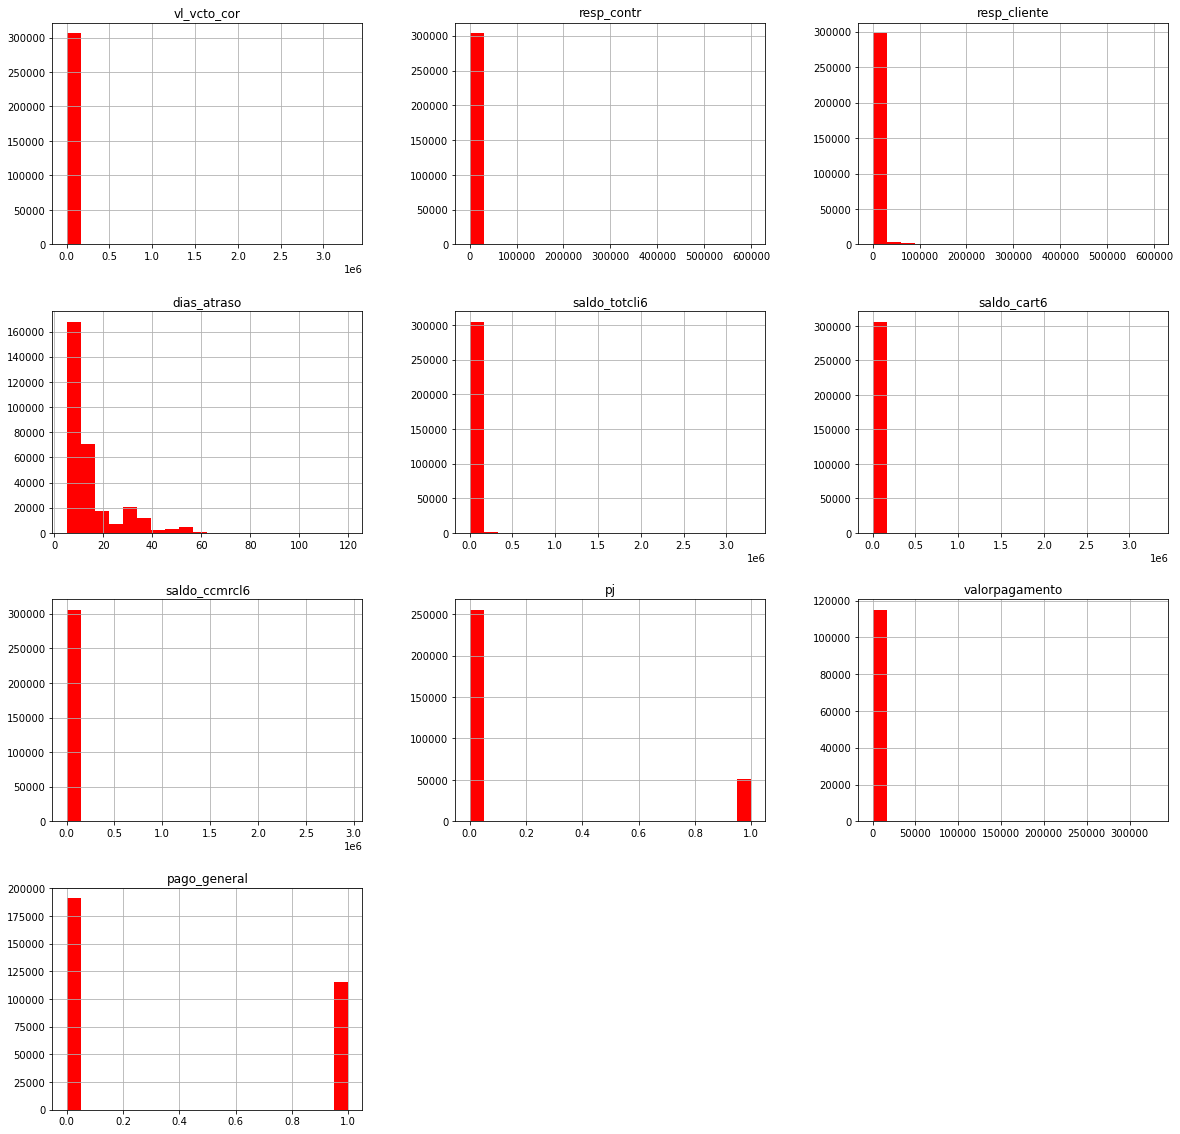

In [444]:
df.hist(bins = 20, figsize = (20,20), color = 'r')

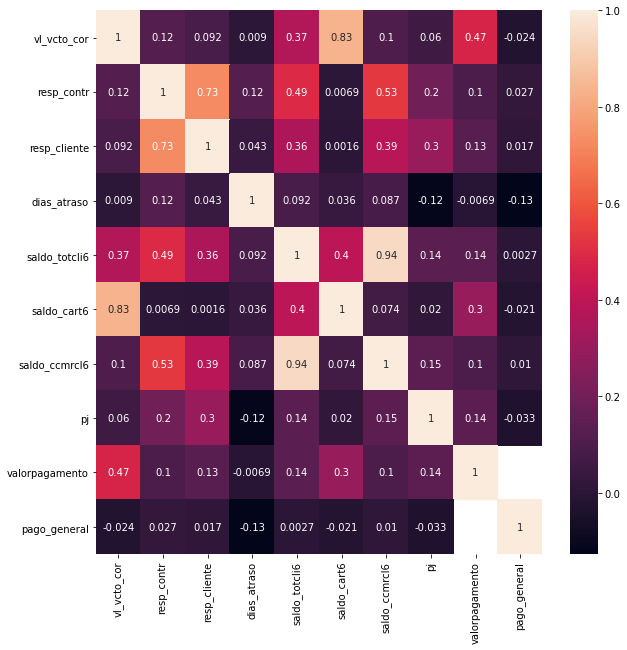

In [445]:
plt.figure(figsize = (10,10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True)
plt.show()

In [446]:
print(list(df.columns))

['location', 'banco', 'agencia', 'dir_reg', 'dt_nasc', 'uf', 'iden_tel1', 'ddd_tel1', 'iden_tel2', 'ddd_tel2', 'iden_tel3', 'ddd_tel3', 'iden_tel4', 'ddd_tel4', 'iden_tel5', 'ddd_tel5', 'iden_tel6', 'ddd_tel6', 'rating', 'dt_desde', 'nat_oper', 'carteira', 'vcto_antig', 'vl_vcto_cor', 'resp_contr', 'resp_cliente', 'ident_seg', 'produto', 'subproduto', 'familia', 'convenio', 'bs1', 'cs1', 'num_contrato', 'dias_atraso', 'saldo_totcli6', 'saldo_cart6', 'saldo_ccmrcl6', 'dataasig', 'pj', 'cpf11', 'valorpagamento', 'datapagamento', 'pago_general']


drop highly correlated variables

In [447]:
df = df.drop(['saldo_ccmrcl6', 'vl_vcto_cor', 'resp_contr'  ], axis = 1) 

In [448]:
df['location'].value_counts()

101010    254770
010102     30772
301010     20805
Name: location, dtype: int64

In [449]:
df['banco'].value_counts()

       275575
237     30772
Name: banco, dtype: int64

In [450]:
df['agencia'].value_counts()

04025    39936
03750     3659
03726      723
00265      340
00452      301
         ...  
3809         1
2262         1
5873         1
5196         1
1785         1
Name: agencia, Length: 8669, dtype: int64

In [451]:
df = pd.get_dummies(df, columns = ['location', 'banco', 'uf', 'rating', 'ident_seg', 'bs1', 'cs1'], drop_first = True)

In [452]:
def dum_sign(dummy_col, threshold=0.1):
    """ This function returns a dummified dataframe of significant dummies in
    a given column. """

    # removes the bind
    dummy_col = dummy_col.copy()

    # what is the ratio of a dummy in whole column
    count = pd.value_counts(dummy_col) / len(dummy_col)

    # cond whether the ratios is higher than the threshold
    mask = dummy_col.isin(count[count > threshold].index)

    # replace the ones which ratio is lower than the threshold by a special name
    dummy_col[~mask] = "others"

    return pd.get_dummies(dummy_col, prefix=dummy_col.name)

In [453]:
dummy = pd.Series(df['agencia'], name='agencia')
dummy_df= dum_sign(dummy, 0.01)

In [454]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('agencia', axis = 1) 

In [455]:
df['dir_reg'].value_counts()

        275575
4264       490
8533       392
8565       385
4669       384
         ...  
4678         3
8761         2
4631         2
4090         1
4024         1
Name: dir_reg, Length: 131, dtype: int64

dir_reg has aprox. 90% blank. will convert column to zero for blanks 1 non-blank

In [456]:
df['dir_reg'] = df['dir_reg'].apply(lambda x: 0 if x == '' else 1)

In [457]:
df['dt_nasc'] = pd.to_datetime(df['dt_nasc'], errors='coerce')

In [458]:
df['age'] = (df['dataasig'] - df['dt_nasc']).astype('<m8[Y]')
df = df.drop('dt_nasc', axis = 1) 

Telephone variables with ddd can be dropped since we can get valid phone count
using the "V" value in the iden columns.

In [459]:
cols = [c for c in df.columns if c.lower()[:3] != 'ddd']
df = df[cols] 

In [460]:
df['iden_tel1'].value_counts()

X    272696
V     33651
Name: iden_tel1, dtype: int64

will replace valid phone value "V" with 1 so we can get a sum of valid phones

In [461]:
df.iloc[:, 1:7] = df.iloc[:, 1:7].replace({'V': 1,'X':0}).fillna(0)

In [462]:
cols = list(df.columns)

In [463]:
cols = cols[1:7]

In [464]:
df['total_phones'] = df[cols].sum(axis=1)

In [465]:
df.drop(cols, axis=1, inplace=True)

create a new tenure variable using dt_desde and dataasig

In [466]:
df['dt_desde'] = pd.to_datetime(df['dt_desde'], errors='coerce')
df['tenure'] = (df['dataasig'] - df['dt_desde']).astype('<m8[Y]')
df = df.drop('dt_desde', axis = 1) 

In [467]:
df['nat_oper'].value_counts()

3      275575
001     10993
090      7936
013      5057
057      2641
093      1989
012      1438
091       343
058       285
033        33
078        17
102        16
092        12
014         8
007         2
005         2
Name: nat_oper, dtype: int64

In [468]:
dummy = pd.Series(df['nat_oper'], name='nat_oper')
dummy_df= dum_sign(dummy, 0.01)

In [469]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('nat_oper', axis = 1) 

In [470]:
df['carteira'].value_counts()

       275575
455      7936
722      4426
351      2838
379      2758
842      2640
385      2312
DCC      1989
530      1906
227      1431
331       544
729       373
375       343
773       309
469       308
809       285
EXL        95
GFC        45
266        33
771        32
393        30
532        17
288        15
136        13
340        12
CAF        11
712         8
621         6
144         6
448         5
944         5
CFF         5
117         4
451         4
349         4
226         4
263         2
591         2
700         2
404         2
406         2
551         2
039         1
304         1
124         1
510         1
688         1
321         1
044         1
841         1
Name: carteira, dtype: int64

In [471]:
dummy = pd.Series(df['carteira'], name='carteira')
dummy_df= dum_sign(dummy, 0.005)

In [472]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop(['carteira', 'vcto_antig', 'familia'], axis = 1) #vcto_antig same as dias_atraso
#familia highly corr with produto

In [473]:
df['produto'].value_counts()

000    277980
004     15608
011      7936
002      2926
005      1531
019       340
012        18
006         8
Name: produto, dtype: int64

In [474]:
df['prod_000'] = df['produto'].apply(lambda x: 0 if x != '000' else 1)
df['prod_004'] = df['produto'].apply(lambda x: 0 if x != '004' else 1)
df['prod_011'] = df['produto'].apply(lambda x: 0 if x != '011' else 1)
df = df.drop('produto', axis = 1)

In [475]:
df['subprod_000'] = df['subproduto'].apply(lambda x: 0 if x != '000' else 1)
df['subprod_006'] = df['subproduto'].apply(lambda x: 0 if x != '006' else 1)
df['subprod_061'] = df['subproduto'].apply(lambda x: 0 if x != '061' else 1)
df = df.drop('subproduto', axis = 1)

In [476]:
df['convenio'].value_counts()

000000000    295104
000004930      2015
000007537      1902
000009151      1136
000009152       678
              ...  
000007419         1
000016150         1
000005536         1
000005698         1
000011249         1
Name: convenio, Length: 186, dtype: int64

In [477]:
dummy = pd.Series(df['convenio'], name='convenio')
dummy_df= dum_sign(dummy, 0.005)

In [478]:
df = pd.concat([df, dummy_df], axis=1)
df = df.drop('convenio', axis = 1)

get unique count of contracts for each cpf

In [479]:

nval_df = df.groupby('cpf11').num_contrato.agg(nvals='nunique')

merge unique contract count df with original df

In [480]:
df = pd.merge(df, nval_df, left_on ='cpf11', right_on = 'cpf11', how='left')

drop the others column from all dummies to avoid dummy trap

In [481]:
cols = [col for col in df.columns if '_others' not in col]
df = df[cols] 

In [482]:
del cols
del nval_df
del dummy
del dummy_df

In [483]:
df['dir_reg'].head()

0    1
1    0
2    0
3    0
4    0
Name: dir_reg, dtype: int64

In [484]:
df['dir_reg'].value_counts()

0    275575
1     30772
Name: dir_reg, dtype: int64

In [485]:
df.dtypes

dir_reg                 int64
resp_cliente            int32
num_contrato           object
dias_atraso             int16
saldo_totcli6         float32
                       ...   
subprod_061             int64
convenio_000000000      uint8
convenio_000004930      uint8
convenio_000007537      uint8
nvals                   int64
Length: 103, dtype: object

get a subset of variables to review in correlation matrix

In [486]:
corr_df = df.iloc[:, np.r_[0:15, 42:103]]

<AxesSubplot:>

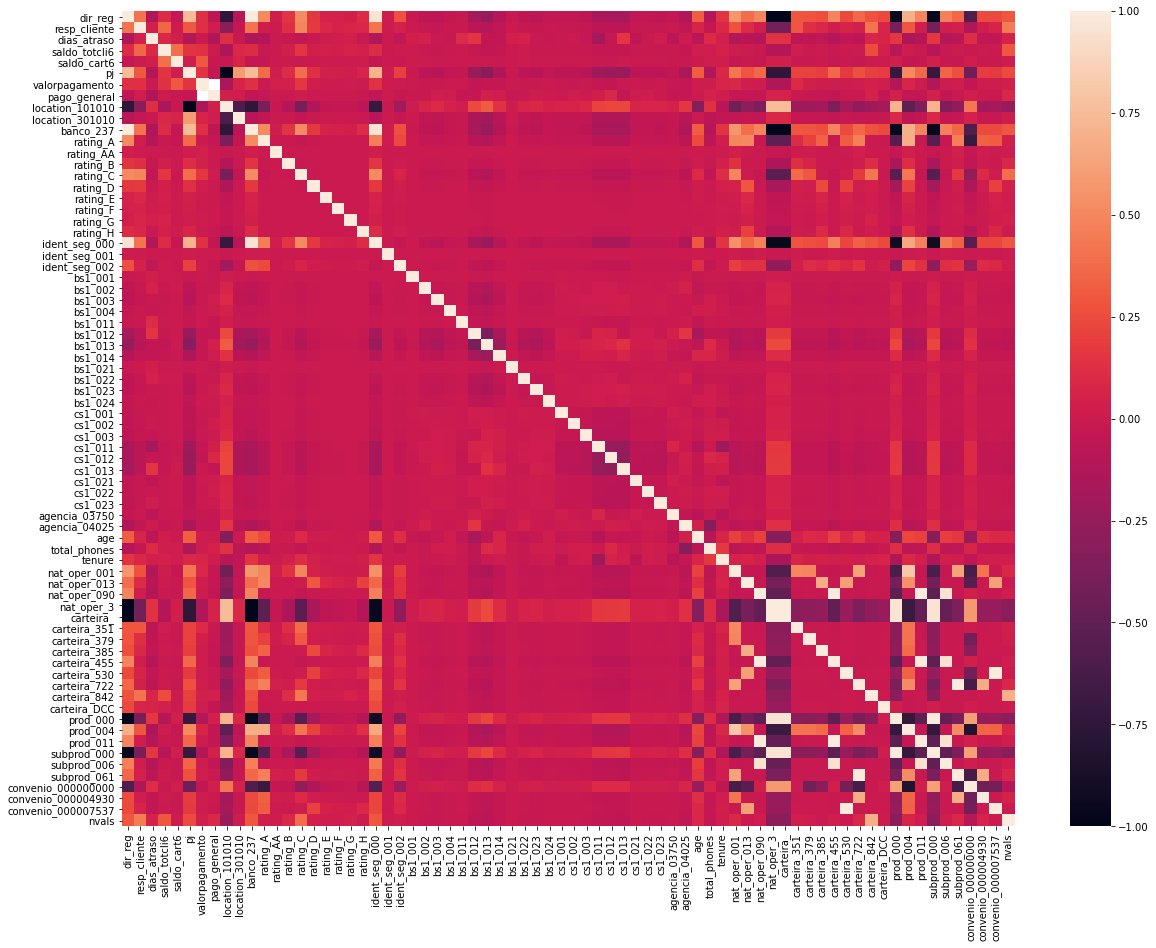

In [487]:
corr_matrix = corr_df.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr_matrix)

will drop one of the pairs from too highly correlated variables.

In [488]:
df = df.drop(['dir_reg', 'ident_seg_000', 'nat_oper_090', 'subprod_006', 'subprod_000', 'subprod_061'] , axis = 1)

## Part 2 Roll Up to a Customer Level

# Get Cumulative Info for key variables then dedupe by CPF

In [489]:
def trans_max(*args, key):
    """ This function transforms the column by performing a groupby on the key
    column and summing the values."""
    
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('max')
    return df[arg]

In [490]:
trans_max('pj',
          'pago_general', 'location_101010', 'location_301010', 'banco_237',
          'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF',
          'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA',
          'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO',
          'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'rating_A',
          'rating_AA', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F',
          'rating_G', 'rating_H', 'ident_seg_002',
          'bs1_001', 'bs1_002', 'bs1_003', 'bs1_004', 'bs1_011', 'bs1_012',
          'bs1_013', 'bs1_014', 'bs1_021', 'bs1_022', 'bs1_023', 'bs1_024',
          'cs1_001', 'cs1_002', 'cs1_003', 'cs1_011', 'cs1_012', 'cs1_013',
          'cs1_021', 'cs1_022', 'cs1_023', 'agencia_03750', 'agencia_04025',
          'nat_oper_001', 'nat_oper_013', 'nat_oper_3', 'carteira_',
          'carteira_351', 'carteira_379', 'carteira_385', 'carteira_455',
          'carteira_530', 'carteira_722', 'carteira_842', 'carteira_DCC',
          'prod_000', 'prod_004', 'prod_011', 'convenio_000000000', 'convenio_000004930',
          'convenio_000007537', 'nvals' , key = 'cpf11')

0         1
1         1
2         1
3         1
4         1
         ..
306342    1
306343    1
306344    1
306345    2
306346    2
Name: nvals, Length: 306347, dtype: int64

In [491]:
def trans_sum(*args, key):
    """ This function transforms the column by performing a groupby on the key
    column and summing the values."""
    
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('sum')
    return df[arg]

In [492]:
trans_sum('resp_cliente','total_phones',
          'saldo_totcli6', 'saldo_cart6','valorpagamento', key='cpf11')

0          2369.94
1             0.00
2             0.00
3           368.74
4             0.00
            ...   
306342     5166.47
306343    13378.34
306344     1235.62
306345      664.63
306346      664.63
Name: valorpagamento, Length: 306347, dtype: float64

In [493]:
def trans_mean(*args, key):
    """ This function transform the column by performing a groupby on the key
    column and summing the values."""
   
    for arg in args:
        df[arg] = df[arg].groupby(df[key]).transform('mean')
    return df[arg]

In [494]:
trans_mean('age', 'tenure', 'dias_atraso', key='cpf11')

0          5.00
1         15.00
2         35.00
3         15.00
4          9.00
          ...  
306342     9.00
306343    11.00
306344    15.00
306345     6.25
306346     6.25
Name: dias_atraso, Length: 306347, dtype: float64

In [495]:
df = df.drop_duplicates(subset=['cpf11'])

In [496]:
print(list(df.columns))

['resp_cliente', 'num_contrato', 'dias_atraso', 'saldo_totcli6', 'saldo_cart6', 'dataasig', 'pj', 'cpf11', 'valorpagamento', 'datapagamento', 'pago_general', 'location_101010', 'location_301010', 'banco_237', 'uf_AC', 'uf_AL', 'uf_AM', 'uf_AP', 'uf_BA', 'uf_CE', 'uf_DF', 'uf_ES', 'uf_GO', 'uf_MA', 'uf_MG', 'uf_MS', 'uf_MT', 'uf_PA', 'uf_PB', 'uf_PE', 'uf_PI', 'uf_PR', 'uf_RJ', 'uf_RN', 'uf_RO', 'uf_RR', 'uf_RS', 'uf_SC', 'uf_SE', 'uf_SP', 'uf_TO', 'rating_A', 'rating_AA', 'rating_B', 'rating_C', 'rating_D', 'rating_E', 'rating_F', 'rating_G', 'rating_H', 'ident_seg_001', 'ident_seg_002', 'bs1_001', 'bs1_002', 'bs1_003', 'bs1_004', 'bs1_011', 'bs1_012', 'bs1_013', 'bs1_014', 'bs1_021', 'bs1_022', 'bs1_023', 'bs1_024', 'cs1_001', 'cs1_002', 'cs1_003', 'cs1_011', 'cs1_012', 'cs1_013', 'cs1_021', 'cs1_022', 'cs1_023', 'agencia_03750', 'agencia_04025', 'age', 'total_phones', 'tenure', 'nat_oper_001', 'nat_oper_013', 'nat_oper_3', 'carteira_', 'carteira_351', 'carteira_379', 'carteira_385', 

In [497]:
df_cpf_vlrpg = df[['cpf11', 'saldo_totcli6', 'valorpagamento']]

In [498]:
df_cpf_vlrpg.head()

,cpf11,saldo_totcli6,valorpagamento
0,00000181304,741.700012,2369.94
1,00000245704,271.809998,0.00
2,00000268321,261.140015,0.00
3,00000367222,362.890015,368.74
4,00000452769,58.599998,0.00


In [499]:
df = df.drop(['num_contrato', 'dataasig', 'cpf11', 'datapagamento'], axis = 1) 

In [500]:
# split the dataframe into target and features

df_target = df['pago_general']
df_final = df.drop(columns =['pago_general', 'valorpagamento'])

In [501]:
imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df_final[['age']])
df_final['age'] = imr.transform(df_final[['age']]).ravel()

# PERFORM DIMENSIONALITY REDUCTION USING PCA ( USING SAGEMAKER)

In [502]:
# standardize the data
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(df_final)

# Apply transform 
df_final = scaler.transform(df_final)


In [503]:
print(df_final.ndim)

2


In [504]:
df_final.nbytes

192580752

In [505]:
import sagemaker
import boto3

# create a Sagemaker session
sagemaker_session = sagemaker.Session()

# define the S3 bucket and prefix that we want to use in this session
bucket = 'bnds-sagemaker-sp'  
prefix = 'cc/pca'  

# get the execution role  

role = sagemaker.get_execution_role()

In [506]:
import io  
import sagemaker.amazon.common as smac # sagemaker common libary

# Code below converts the data in numpy array format to RecordIO format
# This is the format required by Sagemaker PCA

buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
df_matrix = df_final # convert the dataframe into 2-dimensional array
smac.write_numpy_to_dense_tensor(buf, df_final)
buf.seek(0)

# When you write to in-memory byte arrays, it increments 1 every time you write to it
# reset that back to zero 

0

In [507]:
# Code to upload RecordIO data to S3
 
# Key refers to the name of the file 
 
key = 'pca'

#following code uploads the data in record-io format to S3 bucket to be accessed later for training
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)


print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://bnds-sagemaker-sp/eavm/pca/train/pca


In [508]:
# create output placeholder in S3 bucket to store the PCA output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://bnds-sagemaker-sp/eavm/pca/output


In [509]:
# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the pca container image
# Note that all  models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session


from sagemaker.amazon.amazon_estimator import get_image_uri

container = sagemaker.image_uris.retrieve("pca", boto3.Session().region_name)


In [510]:
# pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training


pca = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session,
                                       use_spot_instances = True,
                                       max_run = 300,
                                       max_wait = 600)

# We can tune parameters like the number of features that we are passing in, mode of algorithm, mini batch size and number of pca components


pca.set_hyperparameters(feature_dim=91,
                        num_components=40,
                        subtract_mean=False,
                        algorithm_mode='regular',
                        mini_batch_size=100)


# Pass in the training data from S3 to train the pca model


pca.fit({'train': s3_train_data})



2021-03-24 17:46:41 Starting - Starting the training job...
2021-03-24 17:47:05 Starting - Launching requested ML instancesProfilerReport-1616608001: InProgress
......
2021-03-24 17:48:05 Starting - Preparing the instances for training.........
2021-03-24 17:49:36 Downloading - Downloading input data
2021-03-24 17:49:36 Training - Downloading the training image..Docker entrypoint called with argument(s): train
Running default environment configuration script
[03/24/2021 17:49:53 INFO 140200324290368] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_num_kv_servers': 'auto', '_num_gpus': 'auto'}
[03/24/2021 17:49:53 INFO 140200324290368] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {'feature_dim': '91', 'algorithm_mode': '

Use batch transform for inference instead of deploying endpoint at this time.

In [512]:
# Create a transformer object
transformer = pca.transformer(
    instance_count=1, 
    instance_type='ml.m4.xlarge',
    max_payload=6,
    strategy='MultiRecord',
    output_path=batch_output
)

In [513]:
# upload csv version of dataset for use in batch transform instead of invoking endpoint:
pd.DataFrame(df_final).to_csv('test.csv', index=False, header=False)

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')

In [514]:
# The location of the test dataset
batch_input = 's3://{}/{}/test/test.csv'.format(bucket, prefix)

In [515]:
# Initiate the batch transform job by executing the transform() method of the transformer object
transformer.transform(
    data=batch_input, 
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)
transformer.wait()




.................................Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[03/24/2021 17:57:41 INFO 140054024824640] loaded entry point class algorithm.serve.server_config:config_api
[03/24/2021 17:57:41 INFO 140054024824640] nvidia-smi took: 0.02531147003173828 secs to identify 0 gpus
[03/24/2021 17:57:41 INFO 140054024824640] loading entry points
[03/24/2021 17:57:41 INFO 140054024824640] Loaded iterator creator application/x-labeled-vector-protobuf for content type ('application/x-labeled-vector-protobuf', '1.0')
[03/24/2021 17:57:41 INFO 140054024824640] Loaded iterator creator application/x-recordio-protobuf for content type ('application/x-recordio-protobuf', '1.0')
[03/24/2021 17:57:41 INFO 140054024824640] loaded entry point class algorithm.serve.server_config:config_api
[03/24/2021 17:57:41 INFO 140054024824640] nvidia-smi t

## Part 4 After successfully completing PCA, we are ready to train a new model using XGboost

# After we have a valid pca reduction model, can restart from here to get a new valid xgboost model

In [516]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'eavm/pca' 
result = pd.read_csv('s3://{}/{}/output/test.csv.out'.format(bucket, prefix), header=None)

In [517]:
result.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,"{""projection"":[-0.190308541059494",-0.431000,-0.455174,-0.541057,-1.320531,-0.927051,-0.402134,-0.356223,0.835622,0.067943,...,0.987761,-2.117521,1.448483,-1.196023,-8.947120,1.834282,-3.532674,0.414510,4.433297,10.465603828430176]}
1,"{""projection"":[0.138418436050415",0.001120,0.301824,-0.211635,0.211533,-0.272029,-0.038378,-0.510888,-0.578006,-0.116143,...,-1.632493,-0.455837,-1.050289,-3.471119,-0.414529,-0.923407,-0.138864,-0.199049,-0.066994,-0.698013961315155]}
2,"{""projection"":[1.648079633712768",0.773794,0.913804,1.092126,0.954116,-1.231683,-2.190715,-0.796078,3.435923,0.136425,...,-0.456708,-0.203406,-1.349557,-0.463756,-0.249245,0.200184,-0.007000,-0.102534,-0.068636,-0.956752598285675]}
3,"{""projection"":[-0.610481142997741",0.067148,1.076744,-0.189262,1.391599,-0.870279,2.245078,-0.523610,0.410218,2.408568,...,-0.777368,-0.191408,-0.358977,-0.835111,0.019646,-0.138538,-0.345333,0.218227,-0.265103,-1.088526010513305]}
4,"{""projection"":[0.015675960108637",0.029083,-0.142550,0.018011,0.057127,-0.086045,-0.034934,0.140776,0.280062,-0.279369,...,-1.105049,-0.423532,-2.338597,-0.002558,-0.546320,-0.531977,-0.451757,0.287398,-0.350299,-0.942629873752594]}


In [518]:
replace_values = {'{\"projection\"\:\[': '', '\}':'', '\]':''}
result = result.replace(replace_values, regex=True)  

In [519]:
result.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-0.190308541059494,-0.431000,-0.455174,-0.541057,-1.320531,-0.927051,-0.402134,-0.356223,0.835622,0.067943,...,0.987761,-2.117521,1.448483,-1.196023,-8.947120,1.834282,-3.532674,0.414510,4.433297,10.465603828430176
1,0.138418436050415,0.001120,0.301824,-0.211635,0.211533,-0.272029,-0.038378,-0.510888,-0.578006,-0.116143,...,-1.632493,-0.455837,-1.050289,-3.471119,-0.414529,-0.923407,-0.138864,-0.199049,-0.066994,-0.698013961315155
2,1.648079633712768,0.773794,0.913804,1.092126,0.954116,-1.231683,-2.190715,-0.796078,3.435923,0.136425,...,-0.456708,-0.203406,-1.349557,-0.463756,-0.249245,0.200184,-0.007000,-0.102534,-0.068636,-0.956752598285675
3,-0.610481142997741,0.067148,1.076744,-0.189262,1.391599,-0.870279,2.245078,-0.523610,0.410218,2.408568,...,-0.777368,-0.191408,-0.358977,-0.835111,0.019646,-0.138538,-0.345333,0.218227,-0.265103,-1.088526010513305
4,0.015675960108637,0.029083,-0.142550,0.018011,0.057127,-0.086045,-0.034934,0.140776,0.280062,-0.279369,...,-1.105049,-0.423532,-2.338597,-0.002558,-0.546320,-0.531977,-0.451757,0.287398,-0.350299,-0.942629873752594


In [520]:
# access the scores by iterating through the scores in the predictions
predictions = np.array(result)

In [521]:
predictions

array([['-0.190308541059494', -0.430999755859375, -0.455173879861831,
        ..., 0.41451013088226296, 4.433296680450439,
        '10.465603828430176'],
       ['0.138418436050415', 0.001119523658417, 0.301824241876602, ...,
        -0.199048861861228, -0.066993743181228, '-0.698013961315155'],
       ['1.648079633712768', 0.773794412612915, 0.9138041138648979, ...,
        -0.102533660829067, -0.068636484444141, '-0.956752598285675'],
       ...,
       ['0.017564490437507', 0.027563590556382998, 0.119562357664108,
        ..., -0.231470391154289, 0.062455732375382995,
        '-0.640268504619598'],
       ['-0.559277713298797', 0.084126412868499, -0.473675400018692, ...,
        0.203071177005767, -0.20091356337070398, '-0.890457272529602'],
       ['-0.169272899627685', 0.390179187059402, 0.977512538433075, ...,
        0.304942697286605, -0.232443019747734, '-0.855514705181121']],
      dtype=object)

In [522]:
predictions.shape

(264534, 40)

#  TRAIN AND EVALUATE XGBOOST MODEL ON DATA AFTER DIMENSIONALITY REDUCTION (USING SAGEMAKER)

In [523]:
predictions.shape

(264534, 40)

In [524]:
# Convert the array into dataframe in a way that target variable is set as the first column and is followed by feature columns
# This is because sagemaker built-in algorithm expects the data in this format
# train_data: start with dependent variable in first column:

train_data = pd.DataFrame({'Target':df_target})
train_data

,Target
0,1
1,0
2,0
3,1
4,0
...,...
290431,0
290432,0
290433,1
290434,0


In [525]:
# then add in the independent variables into the train_data dataset
for i in range(predictions.shape[1]):
    train_data[i] = predictions[:,i]

In [526]:
train_data.head()

,Target,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,1,-0.190308541059494,-0.431,-0.455174,-0.541057,-1.32053,-0.927051,-0.402134,-0.356223,0.835622,...,0.987761,-2.11752,1.44848,-1.19602,-8.94712,1.83428,-3.53267,0.41451,4.4333,10.465603828430176
1,0,0.138418436050415,0.00111952,0.301824,-0.211635,0.211533,-0.272029,-0.0383781,-0.510888,-0.578006,...,-1.63249,-0.455837,-1.05029,-3.47112,-0.414529,-0.923407,-0.138864,-0.199049,-0.0669937,-0.698013961315155
2,0,1.648079633712768,0.773794,0.913804,1.09213,0.954116,-1.23168,-2.19071,-0.796078,3.43592,...,-0.456708,-0.203406,-1.34956,-0.463756,-0.249245,0.200184,-0.00700023,-0.102534,-0.0686365,-0.956752598285675
3,1,-0.610481142997741,0.0671484,1.07674,-0.189262,1.3916,-0.870279,2.24508,-0.52361,0.410218,...,-0.777368,-0.191408,-0.358977,-0.835111,0.0196461,-0.138538,-0.345333,0.218227,-0.265103,-1.088526010513305
4,0,0.015675960108637,0.0290826,-0.14255,0.0180115,0.057127,-0.0860452,-0.0349339,0.140776,0.280062,...,-1.10505,-0.423532,-2.3386,-0.0025581,-0.54632,-0.531977,-0.451757,0.287398,-0.350299,-0.942629873752594


In [527]:
train_data = pd.merge(train_data, df_cpf_vlrpg, left_index=True, right_index=True, how='left')


In [528]:
train_data.head()

,Target,0,1,2,3,4,5,6,7,8,...,33,34,35,36,37,38,39,cpf11,saldo_totcli6,valorpagamento
0,1,-0.190308541059494,-0.431,-0.455174,-0.541057,-1.32053,-0.927051,-0.402134,-0.356223,0.835622,...,-1.19602,-8.94712,1.83428,-3.53267,0.41451,4.4333,10.465603828430176,00000181304,741.700012,2369.94
1,0,0.138418436050415,0.00111952,0.301824,-0.211635,0.211533,-0.272029,-0.0383781,-0.510888,-0.578006,...,-3.47112,-0.414529,-0.923407,-0.138864,-0.199049,-0.0669937,-0.698013961315155,00000245704,271.809998,0.00
2,0,1.648079633712768,0.773794,0.913804,1.09213,0.954116,-1.23168,-2.19071,-0.796078,3.43592,...,-0.463756,-0.249245,0.200184,-0.00700023,-0.102534,-0.0686365,-0.956752598285675,00000268321,261.140015,0.00
3,1,-0.610481142997741,0.0671484,1.07674,-0.189262,1.3916,-0.870279,2.24508,-0.52361,0.410218,...,-0.835111,0.0196461,-0.138538,-0.345333,0.218227,-0.265103,-1.088526010513305,00000367222,362.890015,368.74
4,0,0.015675960108637,0.0290826,-0.14255,0.0180115,0.057127,-0.0860452,-0.0349339,0.140776,0.280062,...,-0.0025581,-0.54632,-0.531977,-0.451757,0.287398,-0.350299,-0.942629873752594,00000452769,58.599998,0.00


In [529]:
# shift last three columns to the first position (reorder columns):
cols = list(train_data.columns)
cols = [cols[-3]] + [cols[-2]] + [cols[-1]] + cols[:-3]
train_data = train_data[cols]

In [530]:
train_data.head()

,cpf11,saldo_totcli6,valorpagamento,Target,0,1,2,3,4,5,...,30,31,32,33,34,35,36,37,38,39
0,00000181304,741.700012,2369.94,1,-0.190308541059494,-0.431,-0.455174,-0.541057,-1.32053,-0.927051,...,0.987761,-2.11752,1.44848,-1.19602,-8.94712,1.83428,-3.53267,0.41451,4.4333,10.465603828430176
1,00000245704,271.809998,0.00,0,0.138418436050415,0.00111952,0.301824,-0.211635,0.211533,-0.272029,...,-1.63249,-0.455837,-1.05029,-3.47112,-0.414529,-0.923407,-0.138864,-0.199049,-0.0669937,-0.698013961315155
2,00000268321,261.140015,0.00,0,1.648079633712768,0.773794,0.913804,1.09213,0.954116,-1.23168,...,-0.456708,-0.203406,-1.34956,-0.463756,-0.249245,0.200184,-0.00700023,-0.102534,-0.0686365,-0.956752598285675
3,00000367222,362.890015,368.74,1,-0.610481142997741,0.0671484,1.07674,-0.189262,1.3916,-0.870279,...,-0.777368,-0.191408,-0.358977,-0.835111,0.0196461,-0.138538,-0.345333,0.218227,-0.265103,-1.088526010513305
4,00000452769,58.599998,0.00,0,0.015675960108637,0.0290826,-0.14255,0.0180115,0.057127,-0.0860452,...,-1.10505,-0.423532,-2.3386,-0.0025581,-0.54632,-0.531977,-0.451757,0.287398,-0.350299,-0.942629873752594


# Split Dataset into Training, Validation, and Test

In [531]:
# You can change the % in the next line of code to determine split for Training, Validation, and Testing

train_pct = 0.8

train_data_size = int(train_pct * train_data.shape[0])
train_data_size

211627

In [532]:
# shuffle the data in dataframe and then split the dataframe into train, test and validation sets.
# then make test and valid datasets equal to 50% each of the remaining non training observations.

import sklearn

train_data = sklearn.utils.shuffle(train_data)
train = train_data[:train_data_size]



In [533]:
test = train_data[train_data_size:train_data_size + int((len(train_data) - train_data_size) * 0.50)]

In [534]:
valid = train_data[train_data_size + int(len(test)):]

In [535]:
train.shape, test.shape,valid.shape

((211627, 44), (26453, 44), (26454, 44))

In [536]:
train_data.head()

,cpf11,saldo_totcli6,valorpagamento,Target,0,1,2,3,4,5,...,30,31,32,33,34,35,36,37,38,39
257804,70078680107,1193.689941,0.0,0,-0.507667064666748,2.26247,-0.495614,-1.32409,-0.625478,-0.946609,...,-1.05882,0.142896,0.0632537,0.140951,0.0922326,-0.152303,-0.249805,-0.0956106,-0.0747586,-1.029424548149108
150153,12487679778,1232.000000,0.0,0,0.00374177028425,-0.0602194,0.0151824,0.142398,0.113756,-0.117737,...,-0.809474,-0.10586,-1.27583,1.18096,-0.268329,0.0314305,-0.335858,0.14572,-0.266952,-1.134607195854187
27874,01190550822,209.699997,0.0,0,0.017149604856967,-0.0573785,-0.04893,-0.0319384,0.0137153,-0.0401495,...,1.46968,-0.350825,-0.968844,0.317421,-0.323073,-0.0224459,0.0593627,0.00143311,-0.0335582,-0.666998624801635
280115,89982789368,878.719971,0.0,0,-0.243785098195076,-0.312606,0.509207,-0.768555,1.08525,-1.2262,...,-0.690294,-0.312349,-1.92119,0.10642,-0.267563,-0.0596654,-0.378439,-0.019807,-0.196813,-1.229896426200866
86943,04001682605,637.159973,0.0,0,1.664796829223632,-0.505002,1.01381,1.8885,-1.54569,-0.910826,...,-0.858381,0.0604036,-0.493953,0.801409,-0.189023,0.0905732,-0.217749,0.515902,-0.400635,-0.941687405109405


In [537]:
# output shuffled pickle file with cpf saldo total and valorpagamento for later merge post scores to calculate scorebbf
df_cpf_vlrpg = train_data[['cpf11', 'saldo_totcli6', 'valorpagamento']]
df_cpf_vlrpg.to_pickle('df_cpf_vlrpg.pkl')

del df_cpf_vlrpg

In [538]:
X_test, y_test = test.drop(columns = ['Target', 'cpf11', 'saldo_totcli6', 'valorpagamento']), test['Target']

In [539]:
X_train, y_train = train.drop(columns = ['Target', 'cpf11', 'saldo_totcli6', 'valorpagamento']), train['Target']
X_valid, y_valid = valid.drop(columns = ['Target', 'cpf11', 'saldo_totcli6', 'valorpagamento']), valid['Target']

In [540]:
len(y_train)

211627

In [541]:
X_train.shape, X_test.shape, X_valid.shape

((211627, 40), (26453, 40), (26454, 40))

In [542]:
# drop cpf saldo total and valorpagamento from training and valid datasets that will be used to train the model
train = train.drop(columns = ['cpf11', 'saldo_totcli6', 'valorpagamento'])
valid = valid.drop(columns = ['cpf11', 'saldo_totcli6', 'valorpagamento'])                              

In [543]:
train.head()

,Target,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
257804,0,-0.507667064666748,2.26247,-0.495614,-1.32409,-0.625478,-0.946609,-0.91266,1.45033,2.6682,...,-1.05882,0.142896,0.0632537,0.140951,0.0922326,-0.152303,-0.249805,-0.0956106,-0.0747586,-1.029424548149108
150153,0,0.00374177028425,-0.0602194,0.0151824,0.142398,0.113756,-0.117737,-0.00894099,0.191258,0.201155,...,-0.809474,-0.10586,-1.27583,1.18096,-0.268329,0.0314305,-0.335858,0.14572,-0.266952,-1.134607195854187
27874,0,0.017149604856967,-0.0573785,-0.04893,-0.0319384,0.0137153,-0.0401495,-0.000622531,0.0579126,0.0171663,...,1.46968,-0.350825,-0.968844,0.317421,-0.323073,-0.0224459,0.0593627,0.00143311,-0.0335582,-0.666998624801635
280115,0,-0.243785098195076,-0.312606,0.509207,-0.768555,1.08525,-1.2262,0.883326,1.44902,0.820434,...,-0.690294,-0.312349,-1.92119,0.10642,-0.267563,-0.0596654,-0.378439,-0.019807,-0.196813,-1.229896426200866
86943,0,1.664796829223632,-0.505002,1.01381,1.8885,-1.54569,-0.910826,-1.85642,-1.91479,0.998993,...,-0.858381,0.0604036,-0.493953,0.801409,-0.189023,0.0905732,-0.217749,0.515902,-0.400635,-0.941687405109405


In [544]:
valid.head()

,Target,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
12552,1,-1.372712969779968,-1.99712,1.79268,3.70675,0.256773,-1.63508,-1.3212,-1.11677,-1.93767,...,-0.651589,9.12991e-05,1.17239,-1.85637,0.52576,-0.991463,-0.398651,-1.80939,0.960019,-0.788521230220794
166556,0,-0.049014162272214,-0.083141,-0.237819,-0.0142287,0.105025,0.0954665,-0.059721,0.191603,0.118036,...,1.22207,-0.412592,-1.5607,1.52867,-0.318742,-0.0358576,-0.354326,0.347167,-0.318938,-1.090962290763855
23537,1,-0.120862863957881,-0.0374491,-0.207414,-0.203163,-0.186794,0.0190651,-0.159771,0.0466538,0.210759,...,0.691792,-0.35124,0.157379,0.0945327,0.35564,3.82528,3.15855,1.19666,0.391064,0.875554144382476
155514,1,0.441771209239959,-0.830644,0.668065,0.51264,0.833544,-0.795786,-0.952353,-2.9594,2.61082,...,-0.931115,0.0282555,-0.467456,0.454128,-0.104312,0.10625,-0.196522,-0.05574,-0.125786,-1.100857377052307
99765,0,0.736628770828247,-2.5513,3.34285,-2.82335,-1.03232,2.35365,-1.81232,0.7186,-0.655825,...,-0.254356,0.0899357,0.498772,-1.05572,0.169625,-0.357318,-0.432963,0.126445,-0.244055,-1.065884947776794


In [545]:
# save train and valid data as csv files

train.to_csv('train.csv',header = False, index = False)
valid.to_csv('valid.csv',header = False, index = False)


#### Next cells upload files for batch transformation after model is trained

In [546]:
# upload csv version of test dataset for use in batch transform instead of invoking endpoint:
pd.DataFrame(X_test).to_csv('X-test.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'X-test.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test', key)).upload_file(key)

# Let's print out the batch transform testing data location in s3
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded test data location: {}'.format(s3_test_data))

uploaded test data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/test/X-test.csv


In [547]:
# upload csv version of test dataset dependent variable for later use in analyzing training metrics:
pd.DataFrame(y_test).to_csv('y-test.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'y-test.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'test', key)).upload_file(key)

# Let's print out the data location in s3
s3_y_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded y-test data location: {}'.format(s3_y_test_data))

uploaded y-test data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/test/y-test.csv


In [548]:
# upload csv version of training dataset w/o dependent variable for use in batch transform instead of invoking endpoint:
pd.DataFrame(X_train).to_csv('X-train.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'X-train.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'train', key)).upload_file(key)

# Let's print out the batch transform training data location in s3
s3_Xtrain_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded X-train data location: {}'.format(s3_Xtrain_data))

uploaded X-train data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/train/X-train.csv


In [549]:
# upload csv version of training dependent variable dataset for later use in analyzing training metrics:
pd.DataFrame(y_train).to_csv('y-train.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'y-train.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'train', key)).upload_file(key)

# Let's print out the y training data location in s3
s3_y_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded y-train data location: {}'.format(s3_y_train_data))

uploaded y-train data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/train/y-train.csv


In [550]:
# upload csv version of validation dataset w/o dependent variable for use in batch transform instead of invoking endpoint:
pd.DataFrame(X_valid).to_csv('X-valid.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'X-valid.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'valid', key)).upload_file(key)

# Let's print out the batch transform valid data location in s3
s3_Xvalid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded X-valid data location: {}'.format(s3_Xvalid_data))

uploaded X-valid data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/valid/X-valid.csv


In [551]:
# upload csv version of dependent variable for the validation dataset for use later in analyzing training metrics:
pd.DataFrame(y_valid).to_csv('y-valid.csv', index=False, header=False)

prefix = 'XGBoost-Classifier'
key = 'y-valid.csv'

boto3.Session().resource('s3').Bucket(bucket).Object(
os.path.join(prefix, 'valid', key)).upload_file(key)

# Let's print out the batch transform valid data location in s3
s3_y_valid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded y-valid data location: {}'.format(s3_y_valid_data))

uploaded y-valid data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/valid/y-valid.csv


### Train a new XGboost model

In [552]:
prefix = 'XGBoost-Classifier'
key = 'train.csv'

In [553]:
# read the data from csv file and then upload the data to s3 bucket
with open('train.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

# Let's print out the training data location in s3
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/train/train.csv


In [554]:
prefix = 'XGBoost-Classifier'
key = 'valid.csv'

In [555]:
# reading the data from csv file and then upload the data to s3 bucket
with open('valid.csv','rb') as f:
    # The following code uploads the data into S3 bucket to be accessed later for training
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'valid', key)).upload_fileobj(f)

# Let's print out the validation data location in s3
s3_valid_data = 's3://{}/{}/valid/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_valid_data))

uploaded validation data location: s3://bnds-sagemaker-sp/XGBoost-Classifier/valid/valid.csv


In [556]:
# creates output placeholder in S3 bucket to store the output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://bnds-sagemaker-sp/XGBoost-Classifier/output


In [557]:
# Create "train", "validation" channels to feed in the model
# Source: https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html

train_input = sagemaker.inputs.TrainingInput(s3_data = s3_train_data, content_type='csv',s3_data_type = 'S3Prefix')
valid_input = sagemaker.inputs.TrainingInput(s3_data = s3_valid_data, content_type='csv',s3_data_type = 'S3Prefix')



In [558]:
# create a Sagemaker session
sagemaker_session = sagemaker.Session()

# get the execution role  

role = sagemaker.get_execution_role()

# This code is used to get the training container of sagemaker built-in algorithms
# all we have to do is to specify the name of the algorithm, that we want to use

# Let's obtain a reference to the XGBoost container image
# Note that all  models are named estimators
# You don't have to specify (hardcode) the region, get_image_uri will get the current region name using boto3.Session

container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, '0.90-2')


In [559]:
# pass in the container, the type of instance that we would like to use for training 
# output path and sagemaker session into the Estimator. 
# We can also specify how many instances we would like to use for training


Xgboost_classifier = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count=1, 
                                       instance_type='ml.m4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sagemaker_session,
                                       use_spot_instances = True,
                                       max_run = 300,
                                       max_wait = 600)

# To improve the performance of the model, a hyperparameters tuning job need to be run 

Xgboost_classifier.set_hyperparameters(max_depth=20,
                           eval_metric='auc',
                           objective='binary:logistic',
                           eta = 0.1,
                           num_round = 50,
                           subsample = 1,
                           colsample_bytree = 0.8,
                           gamma = 1            
                           )

In [560]:
# The following cells are for hyperparemeter tuning using random search

In [561]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# Logarithmic scaling
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'lambda': ContinuousParameter(0.01, 10, scaling_type="Logarithmic"),
    'eta': ContinuousParameter(0, 1),
    'max_depth': IntegerParameter(1, 20)
}

In [562]:
objective_metric_name = 'validation:auc'

In [563]:
# Random Search
tuner_log = HyperparameterTuner(
    Xgboost_classifier,
    objective_metric_name,
    hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=10,
    strategy='Random'
)

tuner_log.fit({'train': train_input, 'validation': valid_input}, include_cls_metadata=False)

...............................................................................................................................................................!


In [564]:
# check to see if hyperparameter tuning job started
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

In [565]:
# check jobs have finished
status_log = boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']
assert status_log == 'Completed', "First must be completed, was {}".format(status_log)


## Part 5 Get predictions (inference) for Training, Validation, and Test datasets for use in analyzing the effectiveness of the model.

## Get Predictions for Test Dataset

The next four cells are for batch inference from a pre-existing model saved in Sagemaker. Turn these cells on or off depending
on whether or not you want to use a pre-existing model or a newly created one during this kernel processing.

In [566]:
from time import gmtime, strftime
import sagemaker
import boto3

Modelname = 'EAVM-Brad-Algar-PCA-XG-24-03-2021' # the fine tuned model name we already have
transformJobName = 'xgboost-test-batch-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [567]:
client = boto3.client('sagemaker')

In [568]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the testing dataset
batch_input = 's3://{}/{}/test/X-test.csv'.format(bucket,prefix) # test data used for prediction
output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

In [569]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )


The next three cells are for getting batch predictions from a newly created model (one that was created during current kernel processing. Turn these cells off if you used the four cells above for inference from a previously stored model.

In [3]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
XGB_prediction_test = pd.read_csv('s3://{}/{}/output/X-test.csv.out'.format(bucket, prefix), header=None)

In [4]:
len(XGB_prediction_test)

26453

In [5]:
XGB_prediction_test.head()

,0
0,0.407320
1,0.326674
2,0.312938
3,0.277948
4,0.169695


In [6]:
predicted_test = np.array(XGB_prediction_test).astype('float32')

In [7]:
predicted_test

array([[0.40732047],
       [0.32667398],
       [0.31293774],
       ...,
       [0.15607376],
       [0.11161646],
       [0.26515543]], dtype=float32)

In [8]:
len(XGB_prediction_test)

26453

In [9]:
len(predicted_test)

26453

In [10]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
y_test = pd.read_csv('s3://{}/{}/test/y-test.csv'.format(bucket, prefix), header=None)

In [11]:
y_test = np.array(y_test)
y_test = y_test.reshape(-1,1)

In [12]:
y_test

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [13]:
len(y_test)

26453

The next four cells are for batch inference from a pre-existing model saved in Sagemaker. Turn these cells on or off depending
on whether or not you want to use a pre-existing model or a newly created one during this kernel processing.

In [570]:
from time import gmtime, strftime
import sagemaker
import boto3

Modelname = 'EAVM-Brad-Algar-PCA-XG-24-03-2021' # the fine tuned model name we already have
transformJobName = 'xgboost-train-batch-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [571]:
client = boto3.client('sagemaker')

In [572]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the training dataset
batch_input = 's3://{}/{}/train/X-train.csv'.format(bucket,prefix) # training data used for prediction
output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

In [573]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )


The next three cells are for getting batch predictions from a newly created model (one that was created during current kernel processing. Turn these cells off if you used the four cells above for inference from a previously stored model.

In [14]:
XGB_prediction_train = pd.read_csv('s3://{}/{}/output/X-train.csv.out'.format(bucket, prefix), header=None)


In [15]:
XGB_prediction_train.head()

,0
0,0.353785
1,0.321040
2,0.209835
3,0.348714
4,0.348432


In [16]:
XGB_prediction_train

,0
0,0.353785
1,0.321040
2,0.209835
3,0.348714
4,0.348432
...,...
211622,0.549416
211623,0.275144
211624,0.245068
211625,0.421628


In [17]:
predict_train = np.array(XGB_prediction_train).astype('float32')

In [18]:
predict_train

array([[0.3537854 ],
       [0.32103986],
       [0.20983498],
       ...,
       [0.24506754],
       [0.42162776],
       [0.20889316]], dtype=float32)

In [19]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
y_train = pd.read_csv('s3://{}/{}/train/y-train.csv'.format(bucket, prefix), header=None)

In [20]:
y_train = np.array(y_train)
y_train = y_train.reshape(-1,1)

In [21]:
len(y_train)

211627

In [22]:
y_train

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

## Get Predictions for Validation Dataset

The next four cells are for batch inference from a pre-existing model saved in Sagemaker. Turn these cells on or off depending
on whether or not you want to use a pre-existing model or a newly created one during this kernel processing.

In [574]:
from time import gmtime, strftime
import sagemaker
import boto3

Modelname = 'EAVM-Brad-Algar-PCA-XG-24-03-2021' # the fine tuned model name we already have
transformJobName = 'xgboost-valid-batch-'+ strftime("%Y-%m-%d-%H-%M-%S", gmtime())

In [575]:
client = boto3.client('sagemaker')

In [576]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 

# The location of the validation dataset
batch_input = 's3://{}/{}/valid/X-valid.csv'.format(bucket,prefix) # validation data used for prediction
output_location = 's3://{}/{}/output'.format(bucket, prefix)
batch_output = output_location

In [577]:
create_batch = client.create_transform_job(
    TransformJobName=transformJobName,
    ModelName=Modelname,
    MaxConcurrentTransforms=0,
    MaxPayloadInMB=6,
    BatchStrategy='MultiRecord',
    TransformInput={
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': batch_input 
            }
        },
        'ContentType': 'text/csv',
        'CompressionType': 'None',
        'SplitType': 'Line'
    },
    TransformOutput={
        'S3OutputPath': batch_output,
        'AssembleWith': 'Line'
    },
    TransformResources={
        'InstanceType': 'ml.m4.xlarge',
        'InstanceCount': 1
    }
    )


The next three cells are for getting batch predictions from a newly created model (one that was created during current kernel processing. Turn these cells off if you used the four cells above for inference from a previously stored model.

In [23]:
XGB_prediction_valid = pd.read_csv('s3://{}/{}/output/X-valid.csv.out'.format(bucket, prefix), header=None)

In [24]:
XGB_prediction_valid.head()

,0
0,0.795761
1,0.346628
2,0.326298
3,0.253070
4,0.403289


In [25]:
XGB_prediction_valid

,0
0,0.795761
1,0.346628
2,0.326298
3,0.253070
4,0.403289
...,...
26449,0.377101
26450,0.285359
26451,0.140823
26452,0.373683


In [26]:
predict_valid = np.array(XGB_prediction_valid).astype('float32')

In [27]:
predict_valid

array([[0.79576063],
       [0.3466277 ],
       [0.32629824],
       ...,
       [0.14082289],
       [0.37368274],
       [0.32359648]], dtype=float32)

In [28]:
bucket = 'bnds-sagemaker-sp'  
prefix = 'XGBoost-Classifier' 
y_valid = pd.read_csv('s3://{}/{}/valid/y-valid.csv'.format(bucket, prefix), header=None)

In [29]:
y_valid = np.array(y_valid)
y_valid = y_valid.reshape(-1,1)

In [30]:
y_valid

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

## Part 6 Analyze the Results

## Plots for Train, Valid and Test

In [606]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, predicted_test)
tr_fpr, tr_tpr, _ = roc_curve(y_train, predict_train)
vr_fpr, vr_tpr, _ = roc_curve(y_valid, predict_valid)

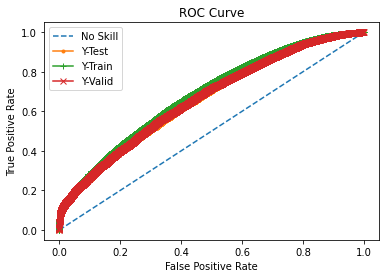

In [607]:
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Y-Test')
plt.plot(tr_fpr, tr_tpr, marker='+', label='Y-Train')
plt.plot(vr_fpr, vr_tpr, marker='x', label='Y-Valid') 

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# title
plt.title('ROC Curve')
# show the plot
plt.show()

In [608]:
auc_test = roc_auc_score(y_test, predicted_test)
print('AUC Test: ',auc_test)
auc_valid = roc_auc_score(y_valid, predict_valid)
print('AUC Validation: ',auc_valid)
auc_train = roc_auc_score(y_train, predict_train)
print('AUC Training: ',auc_train)


AUC Test:  0.658506937911968
AUC Validation:  0.6655141073512192
AUC Training:  0.6876379911252153


# Generate Benefit Score

### Start with the Test dataset

In [31]:
df_cpf_vlrpg = pd.read_pickle('df_cpf_vlrpg.pkl')

In [32]:
test_df = XGB_prediction_test

In [33]:
test_df = pd.merge(test_df, df_cpf_vlrpg, left_index=True, right_index=True, how='left')

In [34]:
test_df.rename(columns={0:'ScoreProb'}, inplace=True)

In [35]:
pg_df = pd.DataFrame(y_test)

In [36]:
test_df = pd.merge(test_df, pg_df, left_index=True, right_index=True, how='left')

In [37]:
test_df.rename(columns={0:'PagoGeneral'}, inplace=True)

In [38]:
test_df['NewSaldoTot'] = test_df['saldo_totcli6']

In [39]:
test_df['NewSaldoTot'].values[test_df['NewSaldoTot'] > 30000] = 30000

In [40]:
test_df['ScoreBeneficio'] = (test_df['ScoreProb']**2 * test_df['NewSaldoTot'])

In [41]:
test_df = test_df[test_df['saldo_totcli6'].notna()]

In [42]:
test_df.sample(5)

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio
16893,0.537480,00810156955,7921.719727,4032.65,1,7921.719727,2288.465520
20560,0.205695,00931661684,145.740005,0.00,0,145.740005,6.166314
25426,0.348164,01110394022,2408.729980,0.00,0,2408.729980,291.982179
315,0.357512,00020659164,360.380005,0.00,0,360.380005,46.061809
5470,0.372471,00318496425,303.799988,0.00,1,303.799988,42.147645


In [43]:
test_df.describe()

,ScoreProb,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio
count,21707.000000,2.170700e+04,21707.000000,21707.000000,21707.000000,21707.000000
mean,0.331218,1.538568e+04,963.933011,0.330631,4430.204102,565.546010
std,0.135993,2.005132e+05,7288.647204,0.470451,8000.002930,1528.406596
min,0.031883,4.935000e+01,0.000000,0.000000,49.349998,0.104800
25%,0.269826,3.793650e+02,0.000000,0.000000,379.365005,32.160156
50%,0.326621,1.061780e+03,0.000000,0.000000,1061.780029,103.666669
75%,0.378111,3.528500e+03,238.400000,1.000000,3528.500000,378.231805
max,0.963530,1.577705e+07,462167.200000,1.000000,30000.000000,27851.684830


In [44]:
test_df = test_df.sort_values(by=['ScoreBeneficio'], ascending=False)

In [45]:
test_df['CumPmnt'] = test_df['valorpagamento'].cumsum()

In [46]:
test_df['CumPmnt%'] = 100*(test_df.CumPmnt.cumsum() / test_df.CumPmnt.sum())

In [47]:
test_df['Freq'] = np.arange(1,len(test_df)+1)

In [48]:
test_df['CumFreq%'] = 100*(test_df.Freq.cumsum() / test_df.Freq.sum())

In [49]:
test_df.head()

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio,CumPmnt,CumPmnt%,Freq,CumFreq%
15935,0.963530,00774004371,105549.781250,0.00,1,30000.0,27851.684830,0.00,0.000000,1,4.244342e-07
8559,0.955322,00457888940,405473.343750,179042.64,1,30000.0,27379.208686,179042.64,0.000049,2,1.273303e-06
4616,0.951592,00272472936,62962.011719,0.00,1,30000.0,27165.794415,179042.64,0.000097,3,2.546605e-06
13957,0.950125,00708453284,55432.539062,0.00,1,30000.0,27082.124273,179042.64,0.000146,4,4.244342e-06
9190,0.946646,00483896464,32091.898438,0.00,1,30000.0,26884.185150,179042.64,0.000194,5,6.366513e-06


In [50]:
# bin the dataframe into deciles:
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
test_df['Decile'] = pd.qcut(x=test_df['Freq'], q=10, labels=labels, precision=0)

In [51]:
test_df.tail()

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio,CumPmnt,CumPmnt%,Freq,CumFreq%,Decile
20185,0.051614,00921547196,57.169998,57.17,0,57.169998,0.152304,20923952.75,99.977305,21703,99.963150,10
24544,0.041218,01083069970,84.190002,84.19,0,84.190002,0.143029,20924036.94,99.982979,21704,99.972362,10
13812,0.046405,00703866176,59.990002,0.00,0,59.990002,0.129185,20924036.94,99.988652,21705,99.981574,10
12263,0.047953,00612563316,51.209999,56.92,0,51.209999,0.117755,20924093.86,99.994326,21706,99.990787,10
16823,0.042864,00807797520,57.040001,0.00,0,57.040001,0.104800,20924093.86,100.000000,21707,100.000000,10


In [52]:
decile_test_df = test_df.groupby('Decile').agg({'Freq': 'count', 'saldo_totcli6': 'mean', 'ScoreBeneficio': 'mean', 'PagoGeneral': 'sum',
                                           'valorpagamento': 'sum'})

In [53]:
decile_test_df['CumFreq%'] = 100*(decile_test_df.Freq.cumsum() / decile_test_df.Freq.sum())

In [54]:
decile_test_df['CumPG%'] = 100*(decile_test_df.PagoGeneral.cumsum() / decile_test_df.PagoGeneral.sum())

In [55]:
decile_test_df['%GoodCPF'] = 100*(decile_test_df['PagoGeneral'] / decile_test_df.PagoGeneral.sum())

In [56]:
decile_test_df['AcumPmnt'] = decile_test_df['valorpagamento'].cumsum()

In [57]:
decile_test_df['CumPmnt%'] = 100*(decile_test_df.valorpagamento.cumsum() / decile_test_df.valorpagamento.sum())

In [58]:
decile_test_df['%Pmnts'] = 100*(decile_test_df['valorpagamento'] / decile_test_df.valorpagamento.sum())

In [59]:
decile_test_df = decile_test_df[['ScoreBeneficio', 'Freq', 'CumFreq%', 'saldo_totcli6', 'PagoGeneral', '%GoodCPF', 'CumPG%',
                     'valorpagamento', 'AcumPmnt', '%Pmnts', 'CumPmnt%']]

In [60]:
decile_test_df

,ScoreBeneficio,Freq,CumFreq%,saldo_totcli6,PagoGeneral,%GoodCPF,CumPG%,valorpagamento,AcumPmnt,%Pmnts,CumPmnt%
Decile,,,,,,,,,,,
1,3808.843421,2171,10.001382,117447.945312,922,12.846593,12.846593,9919860.77,9919860.77,47.408795,47.408795
2,915.133730,2171,20.002764,16762.447266,840,11.704055,24.550648,4475062.62,14394923.39,21.387127,68.795922
3,390.335060,2170,29.999539,4902.128906,857,11.940922,36.491570,2061207.53,16456130.92,9.850881,78.646803
4,215.747231,2171,40.000921,6015.758789,752,10.477916,46.969486,1528890.83,17985021.75,7.306844,85.953647
5,131.211633,2171,50.002303,3564.004883,686,9.558311,56.527797,798939.04,18783960.79,3.818273,89.771920
6,83.905088,2170,59.999079,2809.581299,750,10.450049,66.977846,660054.65,19444015.44,3.154520,92.926440
7,53.778466,2171,70.000461,992.993347,690,9.614045,76.591891,543534.23,19987549.67,2.597648,95.524087
8,32.343161,2170,79.997236,610.630676,655,9.126376,85.718267,418050.50,20405600.17,1.997938,97.522026
9,17.446118,2171,89.998618,416.986145,616,8.582973,94.301240,277540.96,20683141.13,1.326418,98.848444


In [61]:
# add a new row at top of dataframe for plotting to begin at zero for frequency and % of payments
new_row = pd.DataFrame({'CumFreq%': 0, 'CumPmnt%': 0},index =[0])

In [62]:
# concatenate both dataframes
decile_test_df = pd.concat([new_row, decile_test_df]).reset_index(drop = True)

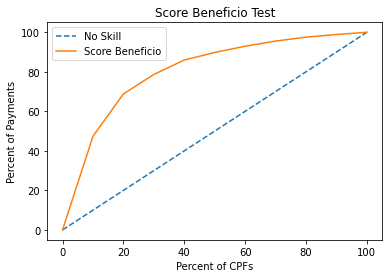

In [63]:
plt.plot(decile_test_df['CumFreq%'], decile_test_df['CumFreq%'], linestyle='--', label='No Skill')
plt.plot(decile_test_df['CumFreq%'], decile_test_df['CumPmnt%'], label='Score Beneficio')

# axis labels
plt.xlabel('Percent of CPFs')
plt.ylabel('Percent of Payments')
# show the legend
plt.legend()
# title
plt.title('Score Beneficio Test')
# show the plot
plt.show()

### Validation Dataset

In [64]:
df_cpf_vlrpg = pd.read_pickle('df_cpf_vlrpg.pkl')

In [65]:
valid_df = XGB_prediction_valid

In [66]:
valid_df = pd.merge(valid_df, df_cpf_vlrpg, left_index=True, right_index=True, how='left')

In [67]:
valid_df.rename(columns={0:'ScoreProb'}, inplace=True)

In [68]:
pg_df = pd.DataFrame(y_test)

In [69]:
valid_df = pd.merge(valid_df, pg_df, left_index=True, right_index=True, how='left')

In [70]:
valid_df.rename(columns={0:'PagoGeneral'}, inplace=True)

In [71]:
valid_df['NewSaldoTot'] = valid_df['saldo_totcli6']

In [72]:
valid_df['NewSaldoTot'].values[valid_df['NewSaldoTot'] > 30000] = 30000

In [73]:
valid_df['ScoreBeneficio'] = (valid_df['ScoreProb']**2 * valid_df['NewSaldoTot'])

In [74]:
valid_df = valid_df[valid_df['saldo_totcli6'].notna()]

In [75]:
valid_df.sample(5)

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio
21668,0.326477,00966077946,9584.559570,10654.22,1.0,9584.559570,1021.589377
8448,0.348401,00452885207,12208.740234,0.00,0.0,12208.740234,1481.939779
23288,0.168108,01047282607,612.090027,0.00,0.0,612.090027,17.297888
24601,0.298571,01084750540,704.309998,968.18,0.0,704.309998,62.785346
9232,0.374217,00485963531,1258.290039,0.00,0.0,1258.290039,176.209330


In [76]:
valid_df.describe()

,ScoreProb,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio
count,21708.000000,2.170800e+04,21708.000000,21707.000000,21708.000000,21708.000000
mean,0.333469,1.538514e+04,963.888606,0.330631,4430.170898,580.721539
std,0.136779,2.005086e+05,7288.482251,0.470451,7999.817871,1529.106724
min,0.030259,4.935000e+01,0.000000,0.000000,49.349998,0.091309
25%,0.272780,3.794375e+02,0.000000,0.000000,379.437508,32.065699
50%,0.328716,1.061865e+03,0.000000,0.000000,1061.864990,105.642222
75%,0.380253,3.528893e+03,238.390000,1.000000,3528.892578,400.501897
max,0.960948,1.577705e+07,462167.200000,1.000000,30000.000000,26984.179838


In [77]:
valid_df = valid_df.sort_values(by=['ScoreBeneficio'], ascending=False)

In [78]:
valid_df['CumPmnt'] = valid_df['valorpagamento'].cumsum()

In [79]:
valid_df['CumPmnt%'] = 100*(valid_df.CumPmnt.cumsum() / valid_df.CumPmnt.sum())

In [80]:
valid_df['Freq'] = np.arange(1,len(valid_df)+1)

In [81]:
valid_df['CumFreq%'] = 100*(valid_df.Freq.cumsum() / valid_df.Freq.sum())

In [82]:
valid_df.head()

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio,CumPmnt,CumPmnt%,Freq,CumFreq%
10680,0.948405,00548196034,39958.910156,6254.16,1.0,30000.0,26984.179838,6254.16,0.000002,1,4.243951e-07
19191,0.947541,00889899039,39992.000000,0.00,1.0,30000.0,26935.011535,6254.16,0.000003,2,1.273185e-06
23099,0.936246,01041587350,39240.800781,1304.64,1.0,30000.0,26296.692585,7558.80,0.000005,3,2.546371e-06
13951,0.927076,00708164409,70551.429688,0.00,0.0,30000.0,25784.073089,7558.80,0.000008,4,4.243951e-06
18351,0.925729,00867285192,51022.007812,0.00,0.0,30000.0,25709.224151,7558.80,0.000010,5,6.365927e-06


In [83]:
# bin the dataframe into deciles:
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
valid_df['Decile'] = pd.qcut(x=valid_df['Freq'], q=10, labels=labels, precision=0)

In [84]:
valid_df.tail()

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio,CumPmnt,CumPmnt%,Freq,CumFreq%,Decile
14762,0.056070,00734360207,50.380001,47.87,0.0,50.380001,0.158385,20924020.36,99.977239,21704,99.963151,10
16486,0.045831,00793194198,70.900002,0.00,0.0,70.900002,0.148924,20924020.36,99.982929,21705,99.972363,10
11051,0.051967,00562856552,50.040001,0.00,0.0,50.040001,0.135134,20924020.36,99.988620,21706,99.981575,10
613,0.044044,00038596403,67.910004,0.00,0.0,67.910004,0.131734,20924020.36,99.994310,21707,99.990787,10
22119,0.035246,01002451027,73.500000,73.50,0.0,73.500000,0.091309,20924093.86,100.000000,21708,100.000000,10


In [85]:
decile_valid_df = valid_df.groupby('Decile').agg({'Freq': 'count', 'saldo_totcli6': 'mean', 'ScoreBeneficio': 'mean', 'PagoGeneral': 'sum',
                                           'valorpagamento': 'sum'})

In [86]:
decile_valid_df['CumFreq%'] = 100*(decile_valid_df.Freq.cumsum() / decile_valid_df.Freq.sum())

In [87]:
decile_valid_df['CumPG%'] = 100*(decile_valid_df.PagoGeneral.cumsum() / decile_valid_df.PagoGeneral.sum())

In [88]:
decile_valid_df['%GoodCPF'] = 100*(decile_valid_df['PagoGeneral'] / decile_valid_df.PagoGeneral.sum())

In [89]:
decile_valid_df['AcumPmnt'] = decile_valid_df['valorpagamento'].cumsum()

In [90]:
decile_valid_df['CumPmnt%'] = 100*(decile_valid_df.valorpagamento.cumsum() / decile_valid_df.valorpagamento.sum())

In [91]:
decile_valid_df['%Pmnts'] = 100*(decile_valid_df['valorpagamento'] / decile_valid_df.valorpagamento.sum())

In [92]:
decile_valid_df = decile_valid_df[['ScoreBeneficio', 'Freq', 'CumFreq%', 'saldo_totcli6', 'PagoGeneral', '%GoodCPF', 'CumPG%',
                     'valorpagamento', 'AcumPmnt', '%Pmnts', 'CumPmnt%']]

In [93]:
decile_valid_df

,ScoreBeneficio,Freq,CumFreq%,saldo_totcli6,PagoGeneral,%GoodCPF,CumPG%,valorpagamento,AcumPmnt,%Pmnts,CumPmnt%
Decile,,,,,,,,,,,
1,3903.249298,2171,10.000921,104884.820312,734.0,10.227114,10.227114,10090140.16,10090140.16,48.222591,48.222591
2,946.842642,2171,20.001843,30209.507812,721.0,10.045980,20.273095,4217731.17,14307871.33,20.157294,68.379885
3,408.116038,2171,30.002764,7943.959473,723.0,10.073847,30.346942,2128038.10,16435909.43,10.170276,78.550161
4,219.728825,2170,39.999079,4174.654297,715.0,9.962380,40.309321,1393491.69,17829401.12,6.659747,85.209908
5,134.351692,2171,50.000000,3127.990967,698.0,9.725512,50.034833,935348.13,18764749.25,4.470197,89.680105
6,85.219835,2171,60.000921,1289.280640,720.0,10.032047,60.066880,788693.48,19553442.73,3.769308,93.449412
7,53.723758,2170,69.997236,919.955994,709.0,9.878779,69.945660,436178.12,19989620.85,2.084574,95.533986
8,32.246521,2171,79.998157,575.596436,713.0,9.934513,79.880173,438179.77,20427800.62,2.094140,97.628126
9,17.221901,2171,89.999079,403.242981,709.0,9.878779,89.758952,248998.02,20676798.64,1.190006,98.818132


In [94]:
# add a new row at top of dataframe for plotting to begin at zero for frequency and % of payments
new_row = pd.DataFrame({'CumFreq%': 0, 'CumPmnt%': 0},index =[0])

In [95]:
# concatenate both dataframes
decile_valid_df = pd.concat([new_row, decile_valid_df]).reset_index(drop = True)

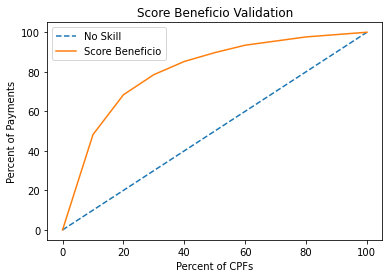

In [96]:
plt.plot(decile_valid_df['CumFreq%'], decile_valid_df['CumFreq%'], linestyle='--', label='No Skill')
plt.plot(decile_valid_df['CumFreq%'], decile_valid_df['CumPmnt%'], label='Score Beneficio')

# axis labels
plt.xlabel('Percent of CPFs')
plt.ylabel('Percent of Payments')
# show the legend
plt.legend()
# title
plt.title('Score Beneficio Validation')
# show the plot
plt.show()

### Training Dataset

In [97]:
df_cpf_vlrpg = pd.read_pickle('df_cpf_vlrpg.pkl')

In [98]:
train_df = XGB_prediction_train

In [99]:
train_df = pd.merge(train_df, df_cpf_vlrpg, left_index=True, right_index=True, how='left')

In [100]:
train_df.rename(columns={0:'ScoreProb'}, inplace=True)

In [101]:
pg_df = pd.DataFrame(y_test)

In [102]:
train_df = pd.merge(train_df, pg_df, left_index=True, right_index=True, how='left')

In [103]:
train_df.rename(columns={0:'PagoGeneral'}, inplace=True)

In [104]:
train_df['NewSaldoTot'] = train_df['saldo_totcli6']

In [105]:
train_df['NewSaldoTot'].values[train_df['NewSaldoTot'] > 30000] = 30000

In [106]:
train_df['ScoreBeneficio'] = (train_df['ScoreProb']**2 * train_df['NewSaldoTot'])

In [107]:
train_df = train_df[train_df['saldo_totcli6'].notna()]

In [108]:
train_df.sample(5)

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio
17707,0.253167,00841181953,83485.421875,0.0,1.0,30000.000000,1922.799158
35463,0.159236,01458346897,140.350006,0.0,NaN,140.350006,3.558725
188710,0.452417,29499089268,615.960022,0.0,NaN,615.960022,126.075310
179542,0.055011,25532302812,70345.140625,0.0,NaN,30000.000000,90.785580
125404,0.244675,08422278812,4217.189941,0.0,NaN,4217.189941,252.466505


In [109]:
train_df.describe()

,ScoreProb,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio
count,189898.000000,1.898980e+05,189898.000000,21707.000000,189898.000000,189898.000000
mean,0.331545,5.552809e+03,515.027822,0.330631,2598.990967,329.876485
std,0.136623,1.228292e+05,3461.427480,0.470451,5618.654297,1009.817945
min,0.027142,4.935000e+01,0.000000,0.000000,49.349998,0.061336
25%,0.269491,3.134225e+02,0.000000,0.000000,313.422508,25.809706
50%,0.327681,7.633250e+02,0.000000,0.000000,763.325012,74.861970
75%,0.378804,1.896385e+03,230.667500,1.000000,1896.385010,215.490859
max,0.963925,3.712785e+07,462167.200000,1.000000,30000.000000,27455.955942


In [110]:
train_df = train_df.sort_values(by=['ScoreBeneficio'], ascending=False)

In [111]:
train_df['CumPmnt'] = train_df['valorpagamento'].cumsum()

In [112]:
train_df['CumPmnt%'] = 100*(train_df.CumPmnt.cumsum() / train_df.CumPmnt.sum())

In [113]:
train_df['Freq'] = np.arange(1,len(train_df)+1)

In [114]:
train_df['CumFreq%'] = 100*(train_df.Freq.cumsum() / train_df.Freq.sum())

In [115]:
train_df.head()

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio,CumPmnt,CumPmnt%,Freq,CumFreq%
96370,0.956660,04969900981,37604.101562,0.0,NaN,30000.0,27455.955942,0.0,0.0,1,5.546090e-09
119912,0.955074,07650390357,32692.560547,0.0,NaN,30000.0,27364.973990,0.0,0.0,2,1.663827e-08
28572,0.950445,01214880222,30828.660156,0.0,NaN,30000.0,27100.353738,0.0,0.0,3,3.327654e-08
12645,0.949156,00627493406,62855.179688,0.0,1.0,30000.0,27026.939746,0.0,0.0,4,5.546090e-08
27990,0.948181,01194535259,56551.761719,0.0,NaN,30000.0,26971.407975,0.0,0.0,5,8.319135e-08


In [116]:
# bin the dataframe into deciles:
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
train_df['Decile'] = pd.qcut(x=train_df['Freq'], q=10, labels=labels, precision=0)

In [117]:
train_df.tail()

,ScoreProb,cpf11,saldo_totcli6,valorpagamento,PagoGeneral,NewSaldoTot,ScoreBeneficio,CumPmnt,CumPmnt%,Freq,CumFreq%,Decile
121367,0.040344,07856548797,63.639999,0.00,NaN,63.639999,0.103585,9.780269e+07,99.997309,189894,99.995787,10
210872,0.036955,38005148852,75.500000,0.00,NaN,75.500000,0.103109,9.780269e+07,99.997982,189895,99.996840,10
156111,0.041130,13849265773,59.279999,59.28,NaN,59.279999,0.100285,9.780275e+07,99.998654,189896,99.997894,10
211553,0.029568,38265966172,108.870003,0.00,NaN,108.870003,0.095181,9.780275e+07,99.999327,189897,99.998947,10
33372,0.030286,01382455682,66.870003,0.00,NaN,66.870003,0.061336,9.780275e+07,100.000000,189898,100.000000,10


In [118]:
decile_train_df = train_df.groupby('Decile').agg({'Freq': 'count', 'saldo_totcli6': 'mean', 'ScoreBeneficio': 'mean', 'PagoGeneral': 'sum',
                                           'valorpagamento': 'sum'})

In [119]:
decile_train_df['CumFreq%'] = 100*(decile_train_df.Freq.cumsum() / decile_train_df.Freq.sum())

In [120]:
decile_train_df['CumPG%'] = 100*(decile_train_df.PagoGeneral.cumsum() / decile_train_df.PagoGeneral.sum())

In [121]:
decile_train_df['%GoodCPF'] = 100*(decile_train_df['PagoGeneral'] / decile_train_df.PagoGeneral.sum())

In [122]:
decile_train_df['AcumPmnt'] = decile_train_df['valorpagamento'].cumsum()

In [123]:
decile_train_df['CumPmnt%'] = 100*(decile_train_df.valorpagamento.cumsum() / decile_train_df.valorpagamento.sum())

In [124]:
decile_train_df['%Pmnts'] = 100*(decile_train_df['valorpagamento'] / decile_train_df.valorpagamento.sum())

In [125]:
decile_train_df = decile_train_df[['ScoreBeneficio', 'Freq', 'CumFreq%', 'saldo_totcli6', 'PagoGeneral', '%GoodCPF', 'CumPG%',
                     'valorpagamento', 'AcumPmnt', '%Pmnts', 'CumPmnt%']]

In [126]:
decile_train_df

,ScoreBeneficio,Freq,CumFreq%,saldo_totcli6,PagoGeneral,%GoodCPF,CumPG%,valorpagamento,AcumPmnt,%Pmnts,CumPmnt%
Decile,,,,,,,,,,,
1,2266.468351,18990,10.000105,40770.031250,1251.0,17.430681,17.430681,45722773.97,45722773.97,46.749987,46.749987
2,436.463350,18990,20.000211,4811.013184,890.0,12.400725,29.831406,15907904.68,61630678.65,16.265293,63.015280
3,219.438013,18990,30.000316,2544.474854,732.0,10.199248,40.030653,9582482.32,71213160.97,9.797763,72.813043
4,136.390042,18989,39.999895,3666.261230,621.0,8.652640,48.683294,7180108.68,78393269.65,7.341418,80.154461
5,91.186235,18990,50.000000,1131.046265,620.0,8.638707,57.322001,5308446.25,83701715.90,5.427706,85.582167
6,61.895757,18990,60.000105,863.392639,630.0,8.778041,66.100042,4067337.48,87769053.38,4.158715,89.740882
7,41.175701,18989,69.999684,620.566589,628.0,8.750174,74.850216,3384629.39,91153682.77,3.460669,93.201551
8,25.963312,18990,79.999789,478.506409,586.0,8.164971,83.015187,2670185.17,93823867.94,2.730174,95.931725
9,14.494438,18990,89.999895,352.178314,601.0,8.373972,91.389160,2111581.67,95935449.61,2.159021,98.090745


In [127]:
# add a new row at top of dataframe for plotting to begin at zero for frequency and % of payments
new_row = pd.DataFrame({'CumFreq%': 0, 'CumPmnt%': 0},index =[0])

In [128]:
# concatenate both dataframes
decile_train_df = pd.concat([new_row, decile_train_df]).reset_index(drop = True)

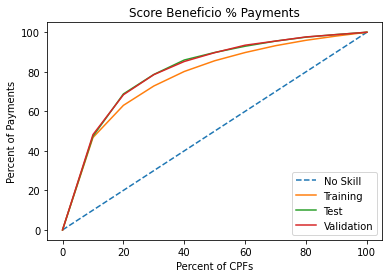

In [129]:
plt.plot(decile_train_df['CumFreq%'], decile_train_df['CumFreq%'], linestyle='--', label='No Skill')
plt.plot(decile_train_df['CumFreq%'], decile_train_df['CumPmnt%'], label='Training')
plt.plot(decile_test_df['CumFreq%'], decile_test_df['CumPmnt%'], label='Test')
plt.plot(decile_valid_df['CumFreq%'], decile_valid_df['CumPmnt%'], label='Validation')

# axis labels
plt.xlabel('Percent of CPFs')
plt.ylabel('Percent of Payments')
# show the legend
plt.legend()
# title
plt.title('Score Beneficio % Payments')
# show the plot
plt.show()

## Confusion Matrix for Training, Validation, and Test datasets

In [130]:
# round predictions for visualization in confusion matrix
predict_train = np.rint(predict_train).astype(int)
predict_valid = np.rint(predict_valid).astype(int)
predicted_test = np.rint(predicted_test).astype(int)

In [131]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [132]:
cm = confusion_matrix(y_train, predict_train)

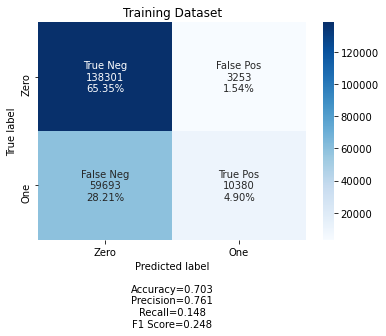

In [133]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Training Dataset')

In [134]:
cm = confusion_matrix(y_valid, predict_valid)

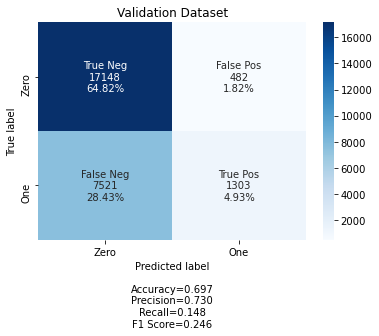

In [135]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Validation Dataset')

In [136]:
cm = confusion_matrix(y_test, predicted_test)

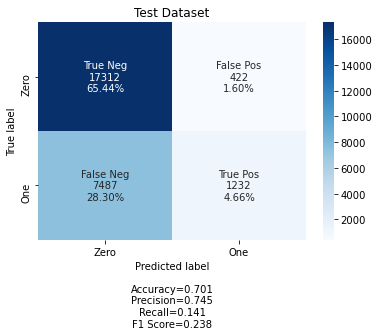

In [137]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories,
                      title='Test Dataset')